# Reinforcement Learning

В этом задании постараемся разобраться в проблеме обучения с подкреплением, реализуем алгоритм REINFORCE и научим агента с помощью этого алгоритма играть в игру Cartpole.

Установим и импортируем необходимые библиотеки, а также вспомогательные функции для визуализации игры агента.

In [1]:
!pip install gym pandas torch matplotlib pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [2]:
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import glob
import time
import io
import base64
import gym
from gym.wrappers.record_video import RecordVideo
import torch
import collections
import pandas as pd
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

In [4]:
!pip install xvfbwrapper
!sudo apt-get install xvfb

  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5009 sha256=fcc37a5d779de97eb506812b54135289ebbf4b9c005e5310808a2ac7e4bfecb9
  Stored in directory: /root/.cache/pip/wheels/cb/10/7d/2b7fdffccf837f7d5425931575fbee9caebe2c190931f9058b
Successfully built xvfbwrapper
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 16 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video')
    return env

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com) это набор сред для разработки и сравнения алгоритмов обучения с подкреплением.

OpenAI Gym предоставляет простой и универсальный API ко многим средам с разными свойствами, как простым так и сложным:
* Классические задачи управления и игрушечные примеры, которые можно найти в учебниках и на которых демонстрируется работа алгоритмов обучения с подкреплением (одна из этих сред используется в этом задании)
* Игры Atari (оказали огромное влияние на достижения в обучении с подкреплением в последние годы)
* 2D и 3D среды для контроля роботов в симуляции (используют проприетарный движок [Mojuco](http://www.mujoco.org))

Рассмотрим, как устроена среда [CartPole-v0](https://gym.openai.com/envs/CartPole-v0), с которой мы будем работать.

Для этого создадим среду.

In [10]:
env = gym.make("CartPole-v1")

Напишем вспомогательную функцию, которая будет принимать на вход среду, агента и число эпизодов, и возвращать среднюю награду за 100 эпизодов. С помощью этой функции мы сможем протестировать, насколько хорошо обучился наш агент, а также визуализировать его поведение в среде.

In [11]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.

    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None -
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
        env.close()

    return np.mean(total_reward)

Протестируем и визуализируем случайного агента (параметр ```agent=False```).

In [12]:
test_agent(env, agent=False, n_episodes=100)

Episode 1 finished after 20 timesteps
Episode 2 finished after 18 timesteps
Episode 3 finished after 19 timesteps
Episode 4 finished after 17 timesteps
Episode 5 finished after 14 timesteps
Episode 6 finished after 94 timesteps
Episode 7 finished after 17 timesteps
Episode 8 finished after 23 timesteps
Episode 9 finished after 54 timesteps
Episode 10 finished after 21 timesteps
Episode 11 finished after 18 timesteps
Episode 12 finished after 16 timesteps
Episode 13 finished after 27 timesteps
Episode 14 finished after 24 timesteps
Episode 15 finished after 13 timesteps
Episode 16 finished after 15 timesteps
Episode 17 finished after 23 timesteps
Episode 18 finished after 13 timesteps
Episode 19 finished after 12 timesteps
Episode 20 finished after 20 timesteps
Episode 21 finished after 19 timesteps
Episode 22 finished after 25 timesteps
Episode 23 finished after 32 timesteps
Episode 24 finished after 28 timesteps
Episode 25 finished after 33 timesteps
Episode 26 finished after 27 times

22.69

Как видно, наш случайный агент выступает не очень хорошо и в среднем может удержать шест всего около 20 шагов.

Напишем функцию для визуализации агента и посмотрим на случайного агента.

In [13]:
def agent_viz(env="CartPole-v1", agent=None):
    """Visualizes agent play in the given environment.

    Args:
        env: The environment for agent to play in. Defaults to CartPole-v0.
        agent: The agent to play with. Defaults to None -
            in this case random agent is used.

    Returns:
        Nothing is returned. Visualization is created and can be showed
            with show_video() function.
    """
    env = wrap_env(gym.make(env, render_mode="rgb_array"))
    observation = env.reset()
    while True:
        env.render()
        if agent:
            with torch.no_grad():
                probs = agent(torch.FloatTensor(observation).to(device))
                dist = Categorical(probs)
                action = dist.sample().item()
        else:
            action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break

    env.close()

In [14]:
agent_viz()
show_video()

Попробуем применить обучение с подкреплением и алгоритм REINFORCE для того, чтобы в среднем за 100 эпиздов мы держали шест не менее 195 шагов.

## REINFORCE

Вспомним, что из себя представляет алгоритм REINFORCE (Sutton & Barto) <img src="//i.imgur.com/bnASTrY.png" width="700">

1. Инициализуем политику (в качестве политики мы будем использовать глубокую нейронную сеть).
2. "Играем" в среде эпизод, используя нашу политику, или несколько (мы будем использовать последний вариант) и собираем данные о состояниях, действиях и полученных наградах.
3. Для каждого состояния в собранных эпизодах вычисляем сумму дисконтированных наград, полученных из этого состояния, а также логорифм правдоподобия предпринятого действия в этом состоянии для нашей политики.
4. Обновляем параметры нашей политики по формуле на схеме.

### Политика

Наша политика должна принимать на вход состояние среды, а на выходе выдавать распределение по действиям, которые мы можем осуществлять в среде.

**Задание:** Создать класс нейронной сети со следующей архитектурой ```Linear -> ReLU -> Linear -> Softmax```. Параметрами инициализации должны служить размерности пространства состояний, пространства действий и размер скрытого слоя.

In [16]:
class Policy(nn.Module):
    """Policy to be used by agent.

    Attributes:
        state_size: Dimention of the state space of the environment.
        act_size: Dimention of the action space of the environment.
        hidden_size: Dimention of the hidden state of the agent's policy.
    """
    def __init__(self, state_size, act_size, hidden_size):
        super(Policy, self).__init__()
        self.brain = nn.Sequential(
            nn.Linear(state_size, hidden_size).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.Linear(hidden_size, act_size).to(device),
            nn.Softmax(dim=0).to(device)
        )

    def forward(self, input):
        return self.brain(input)

### Оценка правдоподобия и расчет суммы дисконтированных наград

**Задание:** Напишем вспомогательная функцию, которая принимает на вход политику, батч траекторий и фактор дисконтирования, и должна вернуть следующие величины:
* правдоподобие действия на каждом шаге на траектории посчитанные для всего батча;
* дисконтированные суммы наград (reward-to-go) из каждого состояния среды на траектории посчитанные для всего батча;

**Hint**: Представим батч траекторий как ```list```, в котром также хранится ```list``` для каждой траектории, в котором каждый шаг хранится, как ```namedtuple```:
```transition = collections.namedtuple("transition", ["state", "action", "reward"])```

In [17]:
def process_traj_batch(policy, batch, discount):
    """Computes log probabilities for each action
        and rewards-to-go for each state in the batch of trajectories.

    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for
            each state in the batch of trajectories.
    """
    log_probs = []
    returns = []

    for trajectory in batch:
        states = [step.state for step in trajectory]
        actions = [step.action for step in trajectory]
        rewards = [step.reward for step in trajectory]

        traj_log_probs = []
        for state, action in zip(states, actions):
            action_probs = policy.forward(state)
            action_prob = action_probs[action]
            traj_log_probs.append(torch.log(action_prob))
        log_probs.extend(traj_log_probs)

        T = len(trajectory)
        trajectory_returns = torch.zeros(T)

        future_reward = 0
        for t in reversed(range(T)):
            future_reward = rewards[t] + discount * future_reward
            trajectory_returns[t] = future_reward
        returns.extend(trajectory_returns)

    return log_probs, returns

Ваша реализация функции должна проходить следующий тест.

In [18]:
def test_process_traj_batch(process_traj_batch):

    transition = collections.namedtuple("transition", ["state", "action", "reward"])

    class HelperPolicy(nn.Module):
        def __init__(self):
            super(HelperPolicy, self).__init__()

            self.act = nn.Sequential(
                nn.Linear(4, 2),
                nn.Softmax(dim=0),
            )

        def forward(self, x):
            return self.act(x)

    policy = HelperPolicy()

    for name, param in policy.named_parameters():
        if name == "act.0.weight":
            param.data = torch.tensor([[1.7492, -0.2471, 0.3310, 1.1494],
                                       [0.6171, -0.6026, 0.5025, -0.3196]])
        else:
            param.data = torch.tensor([0.0262, 0.1882])

    batch = [
        [
            transition(state=torch.tensor([ 0.0462, -0.0018,  0.0372,  0.0063]), action=torch.tensor(0), reward=1.0),
            transition(state=torch.tensor([ 0.0462, -0.1975,  0.0373,  0.3105]), action=torch.tensor(1), reward=1.0),
            transition(state=torch.tensor([ 0.0422, -0.0029,  0.0435,  0.0298]), action=torch.tensor(0), reward=1.0),
            transition(state=torch.tensor([ 0.0422, -0.1986,  0.0441,  0.3359]), action=torch.tensor(0), reward=1.0),
        ],
        [
            transition(state=torch.tensor([ 0.0382, -0.3943,  0.0508,  0.6421]), action=torch.tensor(1), reward=1.0),
            transition(state=torch.tensor([ 0.0303, -0.2000,  0.0637,  0.3659]), action=torch.tensor(1), reward=1.0),
            transition(state=torch.tensor([ 0.0263, -0.0058,  0.0710,  0.0939]), action=torch.tensor(1), reward=1.0),
            transition(state=torch.tensor([ 0.0262,  0.1882,  0.0729, -0.1755]), action=torch.tensor(0), reward=1.0)
        ]
    ]

    log_probs, returns = process_traj_batch(policy, batch, 0.9)
    assert sum(log_probs).item() == -6.3940582275390625, "Log probabilities calculation is incorrect!!!"
    assert sum(returns) == 18.098, "Log probabilities calculation is incorrect!!!"
    print("Correct!")

In [19]:
test_process_traj_batch(process_traj_batch)

Correct!


### Вспомогательные функции и гиперпараметры

Функция для расчета скользящего среднего - ее мы будем использовать для визуализации наград по эпизодам.

In [20]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

Определим также гиперпараметры.

In [72]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = env.action_space.n # размерность пространства действий среды
HIDDEN_SIZE = 256 # размер скрытого слоя для политики
NUM_EPISODES = 1000 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = 0.99 # фактор дисконтирования
TRAIN_EVERY = 20
SUCCESS_SCORE = env.spec.reward_threshold
PIVOT_EPISODES_COUNT = 100

Инициализуем политику и алгоритм оптимизации - мы будем использовать Adam c параметрами по умолчанию.

In [73]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
optimizer = Adam(policy.parameters())

In [74]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

### Основной цикл обучения

Теперь, когда мы опредлели вспомогательные функции, то нам следует написать основной цикл обучения агент.
В цикле должно происходить следующее:

1. Играем количество эпизодов, определенное в гиперпараметре ```NUM_EPISODES```.
2. В каждом эпизоде сохраняем информацию о шагах на траектории - состояние, действие и награду.
3. В конце каждого эпизода сохраняем вышеуказанную информацию о траектории.
4. Периодически обучаемся на собранных эпизодах каждые ```TRAIN_EVERY``` эпизодов:  
    4.1. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.  
    4.2. Обновляем параметры политики агента по формуле, приведенной на схеме.

**Задание:** Реализовать алгоритм обучения, описанный на схеме и в тексте выше. Шаблон кода алгоритма представлен ниже. При этом следует сохранять сумму ревордов для каждого эпизода в переменную ```returns_history```. Алгоритму потребуется около 1000 эпизодов игры, для того чтобы научиться играть в игру (если после 1000 эпизодов агент играет немного хуже, чем для победы в игре, попробуйте обучать его немного дольше или установите критерий останова - когда средняя награда за 100 последних эпизодов превышает значение в ```env.spec.reward_threshold``` )

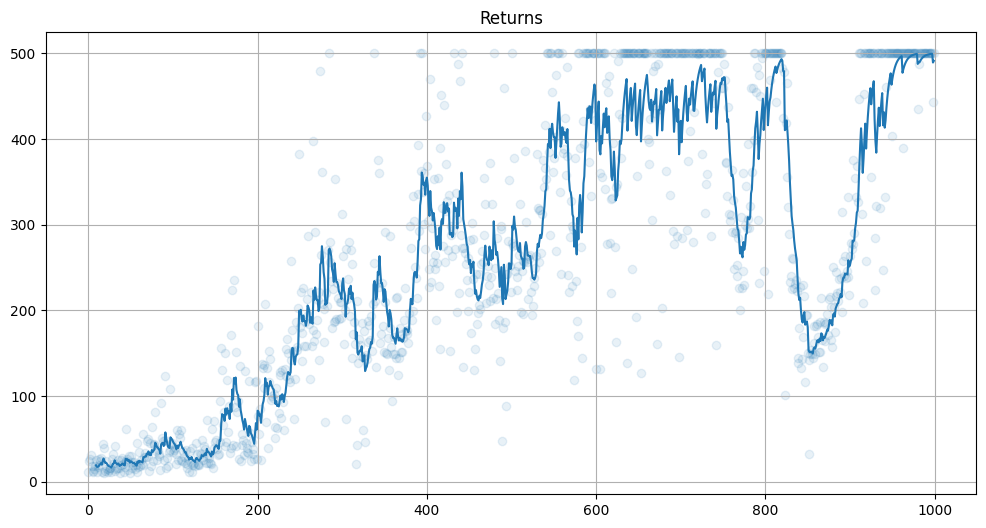

In [75]:
returns_history = []
traj_batch = []

for i in range(NUM_EPISODES):

    t = 0
    observation = env.reset()
    traj = []
    rewards = 0
    reward = 1

    while True:
      #prepeare the action
      probs = policy.forward(torch.FloatTensor(observation).to(device))
      dist = Categorical(probs)
      action = dist.sample().item()

      #store the state
      rewards += reward
      traj.append(
          transition(state = torch.tensor(list(observation)).to(device),
              action = torch.tensor(action).to(device),
              reward = reward
          )
      )
      t += 1

      #perform the action
      observation, reward, done, info = env.step(action)

      if done:
        print(f"Episod {i} finished after {t} timesteps")
        break

    returns_history.append(rewards)
    traj_batch.append(traj)

    if i % TRAIN_EVERY:
        log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
        loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        traj_batch = []

    if i % 10:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.title('Returns'); plt.grid()
        plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        plt.plot(moving_average(returns_history, span=10, min_periods=10))
        plt.show()

    # check win requirement
    last_episodes_score = np.mean(returns_history[-PIVOT_EPISODES_COUNT:])
    if last_episodes_score >= SUCCESS_SCORE:
        print(f"Success score {last_episodes_score} achieved on episod {i}")
        break

Протестируем обученного агента.

In [76]:
test_agent(env, agent=policy, n_episodes=100)

Episode 1 finished after 501 timesteps
Episode 2 finished after 411 timesteps
Episode 3 finished after 501 timesteps
Episode 4 finished after 501 timesteps
Episode 5 finished after 501 timesteps
Episode 6 finished after 501 timesteps
Episode 7 finished after 501 timesteps
Episode 8 finished after 501 timesteps
Episode 9 finished after 469 timesteps
Episode 10 finished after 501 timesteps
Episode 11 finished after 501 timesteps
Episode 12 finished after 481 timesteps
Episode 13 finished after 501 timesteps
Episode 14 finished after 383 timesteps
Episode 15 finished after 476 timesteps
Episode 16 finished after 501 timesteps
Episode 17 finished after 501 timesteps
Episode 18 finished after 501 timesteps
Episode 19 finished after 348 timesteps
Episode 20 finished after 501 timesteps
Episode 21 finished after 501 timesteps
Episode 22 finished after 501 timesteps
Episode 23 finished after 501 timesteps
Episode 24 finished after 501 timesteps
Episode 25 finished after 501 timesteps
Episode 2

479.4

Обученный агент должен приближаться к искомому значению средней награды за 100 эпизодов 195.

Визуализируем обученного агента.

In [77]:
agent_viz(agent=policy)
show_video()

Как видно, агент выучил довольно хорошую стратегию для игры и способен долго удерживать шест.